# Xarray + Cloud OISST (One-Month) Basics & Stats

This notebook demonstrates basic **xarray** operations on a **one-month** subset of a cloud-hosted climate dataset: **NOAA OISST v2.1 daily SST** on AWS Public Datasets (NetCDF files). You'll:
- Discover files for one month on S3 with `fsspec`
- Open them with `xarray.open_mfdataset` (anonymous S3)
- Inspect dataset structure
- Subset in space (and within that month)
- Compute basic stats (mean, std, anomalies relative to the month’s mean)
- Make maps of the month-mean and variability

**Deliverables:** Answer the **🧩 Questions** in the markdown prompts. Fill in the code where indicated by `# TODO`.


In [1]:
import xarray as xr
import fsspec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120


## 1) Open the cloud dataset (NetCDF on AWS, one month)

We'll access **NOAA OISST v2.1 (daily)** in the NOAA CDR bucket on AWS. Files are arranged by **YYYYMM**.

**🧩 Questions**
1. What engine are we using to read NetCDF files from S3?
2. Why do we need `storage_options={'anon': True}`?
3. Inspect dataset attributes: what are the units and long name of `sst`?


1. We are using h5netcdf as the engine to read NetCDF files from S3.
2. The 'anon':True setting is used so that we can access the files without trying to use AWS credentials.
3. sst is short for Daily sea surface temperature, and the units are degrees Celsuis.

In [2]:
yearmonth = "201507"  # TODO: try other months like "201507" or "201909"
prefix = f"noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/{yearmonth}/oisst-avhrr-v02r01.*.nc"

fs = fsspec.filesystem("s3", anon=True)
paths = sorted(fs.glob(prefix))
print(f"Found {len(paths)} files for {yearmonth}. Example:", paths[:2])

urls = [f"s3://{p}" for p in paths]

ds = xr.open_mfdataset(
    urls,
    engine="h5netcdf",
    combine="by_coords",
    decode_times=True,
    mask_and_scale=True,
    backend_kwargs={"storage_options": {"anon": True}},
    chunks={"time": 1}
)

ds


Found 31 files for 201507. Example: ['noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/201507/oisst-avhrr-v02r01.20150701.nc', 'noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/201507/oisst-avhrr-v02r01.20150702.nc']


<xarray.Dataset> Size: 514MB
Dimensions:  (time: 31, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 248B 2015-07-01T12:00:00 ... 2015-07-31T12...
  * zlev     (zlev) float32 4B 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/38)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    Description:                Reynolds, et al.(2007) Daily High-resolution ...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.20150701.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

## 2) Explore coordinates & variables

**🧩 Questions**
1. What are the coordinate names for time and space?
2. What is the shape of `sst`?
3. How are missing values represented?


1. The coordinate name for time is 'time' and the coordinate names for data about space are 'lat' and 'lon'. There is also a coordinate for depth (zlev) but it is the same for every data point (surface).
2. The shape of sst is (31, 1, 720, 1440).
3. Missing values are represented as -999.

In [3]:
list(ds.data_vars), list(ds.coords)

(['anom', 'err', 'ice', 'sst'], ['lat', 'lon', 'time', 'zlev'])

## 3) Time & space subsetting

We'll select a **regional box** (e.g., Gulf of Mexico) within this month.

**🧩 Questions**
1. What lon/lat bounds did you choose?
2. How many daily steps are present in this month?


1. The spatial bounds I chose encompass the Baltic Sea.
2. The month that we pulled (July) has 31 days, and there are 31 values in the 'time' dimension.

In [7]:
var = "sst"

lon_min, lon_max = 9, 31   # TODO
lat_min, lat_max =  53, 66   # TODO

def to_0360(lon):
    lon = np.asarray(lon)
    out = np.mod(lon, 360.0)
    out[out < 0] += 360.0
    return out

lon_min_0360, lon_max_0360 = to_0360([lon_min, lon_max])

dss = ds.sel(
    lon=slice(lon_min_0360, lon_max_0360),
    lat=slice(lat_min, lat_max)
)

dss[var]


<xarray.DataArray 'sst' (time: 31, zlev: 1, lat: 52, lon: 88)> Size: 567kB
dask.array<getitem, shape=(31, 1, 52, 88), dtype=float32, chunksize=(1, 1, 52, 88), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 208B 53.12 53.38 53.62 53.88 ... 65.38 65.62 65.88
  * lon      (lon) float32 352B 9.125 9.375 9.625 9.875 ... 30.38 30.62 30.88
  * time     (time) datetime64[ns] 248B 2015-07-01T12:00:00 ... 2015-07-31T12...
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

## 4) Basic statistics

Compute region-wide stats through time and over space **within this month**.

**🧩 Questions**
1. Compute the spatial mean SST time series over your box. What is the monthly average and standard deviation?
2. Compute within-month anomalies (subtract the month-mean). What are the largest positive and negative anomalies?
3. What day had the warmest/coolest region-mean SST?


1. After calculating spatial mean (new dataset named 'ts'), monthly average SST is 15.18 and the standard deviation is 0.50.
2. Largest positive anomaly is 0.99 C and largest negative anomaly is -1.00 C.
3. Warmest region-mean SST occured on July 5, and coolest region-mean SST was on July 10. 

Month mean SST (°C): 15.184782981872559
Month std SST (°C): 0.5034404397010803


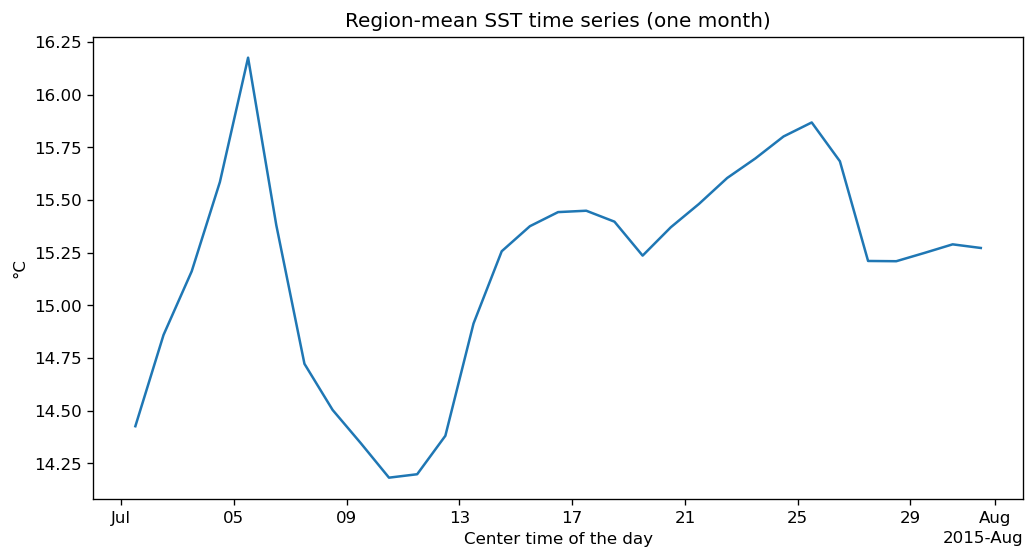

Warmest day: 2015-07-05 16.1759033203125
Coolest day: 2015-07-10 14.181509971618652


/tmp/ipykernel_3162/4235597154.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
/tmp/ipykernel_3162/4235597154.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


/home/briette2/envs/xarray-climate/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/briette2/envs/xarray-climate/lib/python3.13/site-packages/dask/array/reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/briette2/envs/xarray-climate/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [8]:
ts = dss[var].mean(dim=['lat','lon'])

ts_mean = ts.mean().compute()
ts_std  = ts.std().compute()
print('Month mean SST (°C):', float(ts_mean.values))
print('Month std SST (°C):', float(ts_std.values))

ts.load().plot()
plt.title('Region-mean SST time series (one month)')
plt.ylabel('°C')
plt.show()

imax = int(ts.argmax('time'))
imin = int(ts.argmin('time'))
print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


Max anomaly (°C): 0.9911202788352966
Min anomaly (°C): -1.0032726526260376


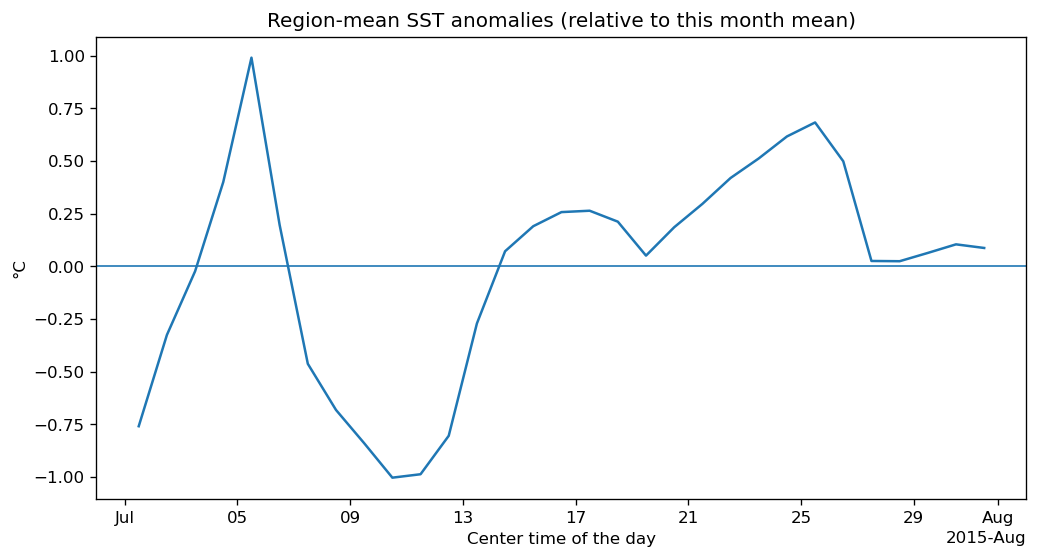

In [9]:
month_mean = dss[var].mean('time')
anom = dss[var] - month_mean

ts_anom = anom.mean(dim=['lat','lon'])
print('Max anomaly (°C):', float(ts_anom.max().compute().values))
print('Min anomaly (°C):', float(ts_anom.min().compute().values))

ts_anom.load().plot()
plt.title('Region-mean SST anomalies (relative to this month mean)')
plt.axhline(0, lw=1)
plt.ylabel('°C')
plt.show()


## 5) Regional maps: month-mean and variability

Make maps of month-mean SST and within-month variability (std and range).

**🧩 Questions**
1. What patterns do you notice?
2. Where is variability strongest?


1. There is a pattern of cooler month-mean SSTs farther north, and warmer month-mean SST in the south and, especially, in the south along the coast where waters are likely shallow. 
2. Variability is the strongest (high standard deviation and high SST range) in the central areas furthest from land. This surprises me.

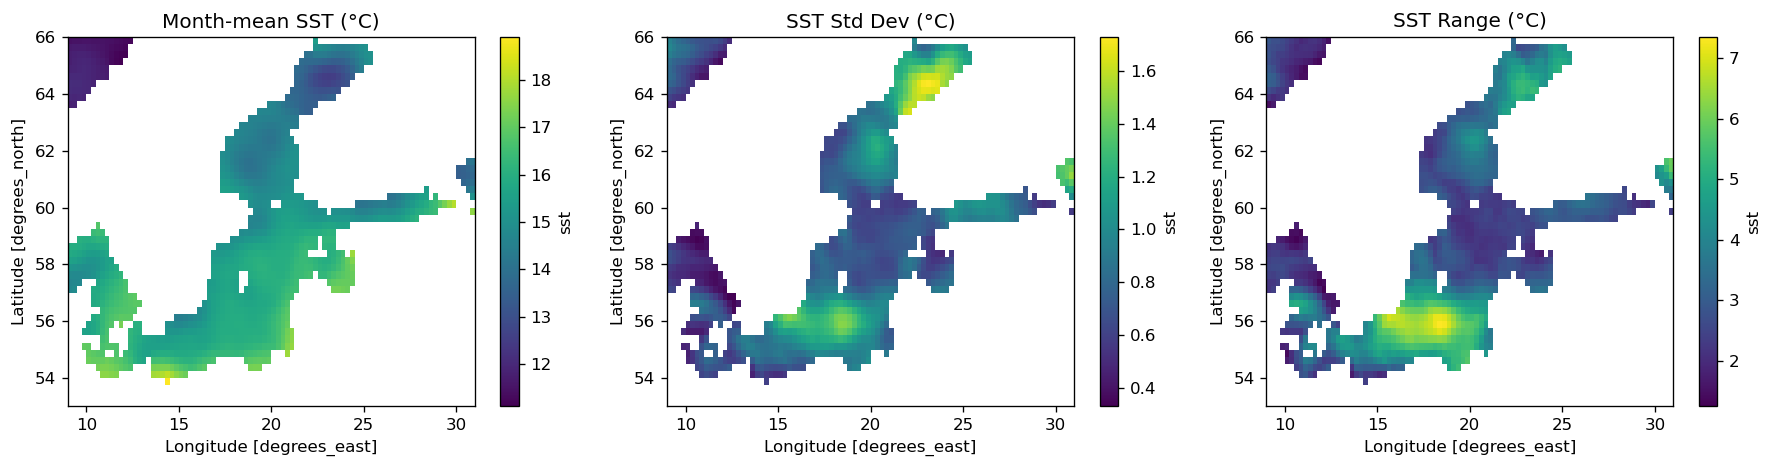

In [10]:
mean_sst = dss[var].mean('time')
std_sst  = dss[var].std('time')
range_sst = dss[var].max('time') - dss[var].min('time')

fig = plt.figure(figsize=(15,4))
ax = plt.subplot(1,3,1); mean_sst.plot(ax=ax); ax.set_title('Month-mean SST (°C)')
ax = plt.subplot(1,3,2); std_sst.plot(ax=ax); ax.set_title('SST Std Dev (°C)')
ax = plt.subplot(1,3,3); range_sst.plot(ax=ax); ax.set_title('SST Range (°C)')
plt.tight_layout(); plt.show()


## 6) Export a small subset for sharing (Check In Problem for Module 2)

Write a NetCDF with your regional mean time series and month-mean/variability maps.  Upload with your committed repository.

In [11]:
out_ds = xr.Dataset(
    {
        "regional_mean_sst": ts,
        "monthly_mean_map": mean_sst,
        "monthly_variability_map": std_sst,
        "sst_range_map": range_sst
    }
)
out_ds.to_netcdf("regional_sst_analysis.nc")